In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import ks_2samp
from scipy.stats import pearsonr
import plotly.figure_factory as ff
# from plotnine import *
# from pyecharts.charts import Map
# from pyecharts import options
%matplotlib inline


In [2]:
# plt.style.use('fivethirtyeight')
plt.style.use('ggplot')

In [3]:
# df = pd.read_excel('../../data/爬取的数据.xlsx', sheet_name='非二手帆船')
df = pd.read_excel('../../data/爬取的数据_copy.xlsx', sheet_name='非二手帆船')
# df.head(1)

In [4]:
df.info() # 有113个 object需要处理。  一共2188个条目。

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2183 entries, 0 to 2182
Columns: 121 entries, Basics.Year to Features.AdditionalEquipment.BeachingLegs
dtypes: float64(26), int64(1), object(94)
memory usage: 2.0+ MB


In [5]:
df.columns # 太多了，分开处理 124
basics_columns = list(filter(lambda x:x.startswith('Basics'), df.columns))
propulsion_columns = list(filter(lambda x:x.startswith('Propulsion'), df.columns))
specification_columns = list(filter(lambda x:x.startswith('Specification'), df.columns))
feature_columns = list(filter(lambda x:x.startswith('Feature'), df.columns))

list(map(len, (basics_columns, propulsion_columns, specification_columns, feature_columns)))
price_column = ['Price']
df[price_column].describe()

,Price
count,1.159000e+03
mean,7.111538e+05
std,1.509767e+06
min,2.144000e+03
25%,1.412770e+05
50%,3.642360e+05
75%,6.882155e+05
max,2.450000e+07


## 针对 Basics进行处理

In [6]:
appropriate_types = {'定类':str, '定序':int, '定距':float, '定比':float}
appropriate_operation = {'定类':'mode', '定序':'median', '定距':'mean', '定比':'mean'}

In [7]:
should_be = ['定距', '定类', '定类', '定类', '定比', '定类', '定类', '定类', '定类', '定比']
should_be = list(map(lambda x: appropriate_types[x], should_be))
basics_columns, should_be

(['Basics.Year',
  'Basics.Make',
  'Basics.Model',
  'Basics.Class',
  'Basics.Length (ft)',
  'Basics.FuelType',
  'Basics.HullMaterial',
  'Basics.OfferedBy',
  'Basics.HullShape',
  'Basics.HullWarranty (years)'],
 [float, str, str, str, float, str, str, str, str, float])

In [8]:
# def len_tran(x):
#     assert x.endswith('ft')
#     return float(x[:-2])
# df['Basics.Length (ft)'] = df['Basics.Length'].map(len_tran)

In [9]:
df[['Basics.Length (ft)', 'Basics.HullWarranty (years)']].tail()

,Basics.Length (ft),Basics.HullWarranty (years)
2178,55.12,NaN
2179,42.65,1 year
2180,85.00,NaN
2181,39.99,NaN
2182,40.03,NaN


In [10]:
'1'.split(' ')[0]
'1 year'.split(' ')[0]
'1 years'.split(' ')[0]

'1'

In [8]:
def war_tran(x):
    x = str(x)
    if x=='nan':
        # return x
        return 0 # 用0填充保险值。
    num = x.split(' ')[0]
    return float(num)
df['Basics.HullWarranty (years)'] = df['Basics.HullWarranty (years)'].map(war_tran)
# df['Basics.HullWarranty (years)'].fillna(0, inplace=True)

In [9]:
df[['Basics.Model', 'Basics.FuelType', 'Basics.HullShape']].value_counts()

Basics.Model     Basics.FuelType  Basics.HullShape
460              Diesel           Monohull            13
Sun Odyssey 410  Diesel           Monohull            12
385              Diesel           Monohull             9
CATSPACE         Diesel           Monohull             9
Oceanis 34.1     Diesel           Catamaran            8
                                                      ..
6 Metre          Diesel           Monohull             1
57               Diesel           Catamaran            1
560              Diesel           Monohull             1
56 Exclusive     Diesel           Monohull             1
x4.0             Diesel           Catamaran            1
Length: 414, dtype: int64

In [10]:
# df[df['Basics.Model'].isnull()]
# df['Basics.Model'] = df['Basics.Model'].dropna()
df = df.dropna(subset=['Basics.Model']) # dropna是一个整体操作

In [11]:
df['Make-Model'] = df['Basics.Make'] + '-' + df['Basics.Model']
# group = df.groupby(['Basics.Make', 'Basics.Model'])

grouper = 'Make-Model'
group = df.groupby(grouper)


In [12]:
datalen = []
for k, v in group:
    # print(k)
    # print(len(v))
    datalen.append(len(v))
    # print(v['Basics.HullShape'].value_counts())
    # print()
# plt.hist(datalen, bins=30)

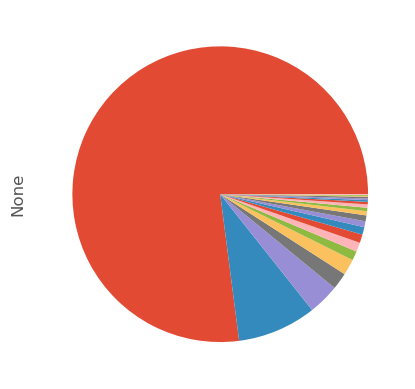

In [13]:
pd.Series(datalen).astype(str).value_counts().plot.pie()

plt.savefig('make-model.png')

In [14]:
cols = ['Basics.FuelType', 'Basics.HullShape'] # 要填充的列
# group_mode = group[cols].agg(lambda x:{x.name: x.mode()} if not  x.isna().sum()==len(x) else None) # 用众数填充
group_mode = group[cols].agg(lambda x:x.mode().sample(frac=1).to_numpy()[0] if not  x.isna().sum()==len(x) else None) # 用众数填充
# group_mode = group[cols].mode()
group_mode
full_mode = df[cols].mode() # 用全局众数填充
full_mode


,Basics.FuelType,Basics.HullShape
0,Diesel,Monohull


In [15]:
# a = group_mode.to_numpy()
# d = {k:v for }
group_mode.loc['A-Yachts-A-33', 'Basics.FuelType']

'Diesel'

In [16]:
def fill_each_row(x, col):
    # print(x[0] if pd.isna(x[0]) else None)
    return group_mode.loc[x[0], col] if pd.isna(x[1]) else x[1]
    
for col in ['Basics.FuelType', 'Basics.HullShape']:
    df[col] = df[['Make-Model', col]].apply(lambda x:fill_each_row(x, col), axis=1)
    df[col] = df[col].fillna(df[col].mode()[0])

In [20]:
# for k, v in group:
#     if len(v)>=5:
#         # 使用组内操作
#         for col in cols:
#             # df[col] = df[col].fillna(df[col].mode())
#             v[col].fillna(v[col].mode(), inplace=True)
#     else:
#         # 使用整个列表的填充
#         for col in cols:
#             # df[col] = df[col].fillna(df[col].mode())
#             v[col].fillna(df[col].mode(), inplace=True)
# # if df[col].isnull().sum()==len(v):
            # #     raise
            # # df[col] = df[col].fillna(v[col].mode())
            # v[col].fillna(v[col].mode(), inplace=True)
            # 想把v内缺失的值填充为组内的众数，但是为什么没能修改原来的df呢？
            # v[col] = v[col].fillna(v[col].mode())

In [17]:
# df[['Basics.Model', 'Basics.FuelType', 'Basics.HullShape']].tail()
df[['Basics.Model', 'Basics.FuelType', 'Basics.HullShape']].describe()

,Basics.Model,Basics.FuelType,Basics.HullShape
count,2183,2183,2183
unique,906,5,9
top,Oceanis 40.1,Diesel,Monohull
freq,28,1962,1664


In [18]:
df[basics_columns].isnull().sum()

Basics.Year                    0
Basics.Make                    0
Basics.Model                   0
Basics.Class                   0
Basics.Length (ft)             0
Basics.FuelType                0
Basics.HullMaterial            0
Basics.OfferedBy               0
Basics.HullShape               0
Basics.HullWarranty (years)    0
dtype: int64

In [19]:
for col, typ in zip(basics_columns, should_be):
    df[col] = df[col].astype(typ)

In [20]:
df[basics_columns].dtypes

Basics.Year                    float64
Basics.Make                     object
Basics.Model                    object
Basics.Class                    object
Basics.Length (ft)             float64
Basics.FuelType                 object
Basics.HullMaterial             object
Basics.OfferedBy                object
Basics.HullShape                object
Basics.HullWarranty (years)    float64
dtype: object

In [22]:
print(df)

      Basics.Year            Basics.Make    Basics.Model    Basics.Class  \
0          2000.0                  Adams              40           Sloop   
1          1987.0                Admiral              40   Racer/Cruiser   
2          2022.0              Aeroyacht              85   Racer/Cruiser   
3          2000.0           African Cats    GreenCat 445   Racer/Cruiser   
4          2023.0               Alliaura      Feeling 55   Racer/Cruiser   
...           ...                    ...             ...             ...   
2178       2008.0               X-Yachts           Xp 50  Centre Cockpit   
2179       2015.0               X-Yachts           Xp 50       Catamaran   
2180       2024.0               X-Yachts            xp44      Multi-Hull   
2181       2023.0               X-Yachts            XP50         Cruiser   
2182       1991.0  Yachting Developments  LUCA BRENTA 74       Catamaran   

      Basics.Length (ft) Basics.FuelType Basics.HullMaterial  \
0                  74.1

## 针对propulsion进行处理

In [23]:
should_be = np.array(['定类', '定比', '定类', '定类', '定类', '定距', '定比', '定类', '定序', '定类', '定序', '定序'])
should_be_type = list(map(lambda x: appropriate_types[x], should_be))
assert len(propulsion_columns) == len(should_be_type)
propulsion_columns, should_be_type

(['Propulsion.EngineMake',
  'Propulsion.TotalPower (hp)',
  'Propulsion.EngineType',
  'Propulsion.FuelType',
  'Propulsion.EngineModel',
  'Propulsion.EngineYear',
  'Propulsion.EngineHours',
  'Propulsion.DriveType',
  'Propulsion.PropellerType',
  'Propulsion.PropellerMaterial',
  'Propulsion.FoldingPropeller',
  'Propulsion.RopeCutter'],
 [str, float, str, str, str, float, float, str, int, str, int, int])

In [24]:
should_be_dict = dict(zip(propulsion_columns, should_be))
prop_discrete_cols = list(filter(lambda x: should_be_dict[x]=='定类' or should_be_dict[x]=='定序', propulsion_columns))
prop_discrete_cols

['Propulsion.EngineMake',
 'Propulsion.EngineType',
 'Propulsion.FuelType',
 'Propulsion.EngineModel',
 'Propulsion.DriveType',
 'Propulsion.PropellerType',
 'Propulsion.PropellerMaterial',
 'Propulsion.FoldingPropeller',
 'Propulsion.RopeCutter']

In [25]:
df[propulsion_columns].dtypes

Propulsion.EngineMake            object
Propulsion.TotalPower (hp)      float64
Propulsion.EngineType            object
Propulsion.FuelType              object
Propulsion.EngineModel           object
Propulsion.EngineYear           float64
Propulsion.EngineHours          float64
Propulsion.DriveType             object
Propulsion.PropellerType         object
Propulsion.PropellerMaterial     object
Propulsion.FoldingPropeller      object
Propulsion.RopeCutter            object
dtype: object

In [26]:
col = 'Propulsion.PropellerType'
df[col].unique()

def tran(x):
    x = str(x)
    if x=='nan' or x=='folding':
        return np.nan
    return float(x.split(' ')[0])
df[col] = df[col].map(tran)

In [27]:
cols = ['Propulsion.FoldingPropeller', 'Propulsion.RopeCutter']
df[cols].describe()
# df[cols[0]].unique()
# df[cols[1]].unique()

def tran(x):
    x = str(x)
    if x=='nan':
        return False
    return True
for col in cols:
    df[col] = df[col].map(tran)

In [28]:
# # df[propulsion_columns].describe()
# # df[prop_discrete_cols].value_counts()
# df[prop_discrete_cols]
# df['Propulsion.PropellerMaterial'].value_counts()
# # df['Propulsion.PropellerMaterial'].isna()   
# df['Propulsion.PropellerMaterial'].head(20)
# df['Propulsion.PropellerMaterial'].mode()
# df['Propulsion.PropellerMaterial'].fillna(df['Propulsion.PropellerMaterial'].mode()[0], inplace=True)

In [34]:
df[propulsion_columns].isna().sum(), prop_discrete_cols


(Propulsion.EngineMake           0
 Propulsion.TotalPower (hp)      0
 Propulsion.EngineType           0
 Propulsion.FuelType             0
 Propulsion.EngineModel          0
 Propulsion.EngineYear           0
 Propulsion.EngineHours          0
 Propulsion.DriveType            0
 Propulsion.PropellerType        0
 Propulsion.PropellerMaterial    0
 Propulsion.FoldingPropeller     0
 Propulsion.RopeCutter           0
 dtype: int64,
 ['Propulsion.EngineMake',
  'Propulsion.EngineType',
  'Propulsion.FuelType',
  'Propulsion.EngineModel',
  'Propulsion.DriveType',
  'Propulsion.PropellerType',
  'Propulsion.PropellerMaterial',
  'Propulsion.FoldingPropeller',
  'Propulsion.RopeCutter'])

In [32]:
def full_and_group_mode(col):
    group_mode = group[col].agg(lambda x:x.mode().sample(frac=1).to_numpy()[0] if not  x.isna().sum()==len(x) else None) # 用众数填充
    # group_mode = group[cols].mode()
    full_mode = df[col].mode().sample(frac=1).to_numpy()[0] # 用全局众数填充； 随机选取众数中的一个
    
    return group_mode, full_mode
# full_and_group_mode('Propulsion.EngineMake')[1]    
def full_and_group_median(col):
    # 求解 col 这一列的组中位数和全局中位数
    group_median = group[col].agg(lambda x:x.median()if not  x.isna().sum()==len(x) else None) 
    full_median = df[col].median() 
    return group_median, full_median

def full_and_group_mean(col):
    # 求解 col 这一列的组均值和全局均值
    group_mean = group[col].agg(lambda x:x.mean()if not  x.isna().sum()==len(x) else None) 
    full_mean = df[col].mean() 
    return group_mean, full_mean
    
op_dict = {'mode':full_and_group_mode, 'median':full_and_group_median, 'mean':full_and_group_mean}

In [33]:
for col in propulsion_columns:
    sh = should_be_dict[col]
    op = appropriate_operation[sh]
    print(f"正在使用{op}填充{col}")
    op = op_dict[op]
    group_stat, full_stat = op(col)


    def fill_each_row(x):
        # print(x[0] if pd.isna(x[0]) else None)
        return group_stat.loc[x[0]] if pd.isna(x[1]) else x[1]
        
    df[col] = df[['Make-Model', col]].apply(lambda x:fill_each_row(x), axis=1)
    print(full_stat)
    df[col].fillna(full_stat, inplace=True)

正在使用mode填充Propulsion.EngineMake
Yanmar
正在使用mean填充Propulsion.TotalPower (hp)
65.96502094281418
正在使用mode填充Propulsion.EngineType
Inboard
正在使用mode填充Propulsion.FuelType
Diesel
正在使用mode填充Propulsion.EngineModel
4JH57
正在使用mean填充Propulsion.EngineYear
2016.2783340907959
正在使用mean填充Propulsion.EngineHours
1177.3771335315398
正在使用mode填充Propulsion.DriveType
Sail Drive
正在使用median填充Propulsion.PropellerType
3.0
正在使用mode填充Propulsion.PropellerMaterial
Bronze
正在使用median填充Propulsion.FoldingPropeller
0.0
正在使用median填充Propulsion.RopeCutter
0.0


## 针对 Specification 进行处理

In [35]:
should_be = np.array(['定比','定比',
                      '定距','定距',
                      '定距','定比',
                      '定比','定比',
                      '定比','定比',
                      '定比','定类',
                      '定比','定比',
                      '定距','定距',
                      '定比','定距',
                      '定比','定比',
                      '定距','定比'])
should_be_type = list(map(lambda x: appropriate_types[x], should_be))
assert len(specification_columns) == len(should_be_type)
specification_columns, should_be_type


(['Specifications.Dimensions.LengthOverall (ft)',
  'Specifications.Dimensions.Beam (ft)',
  'Specifications.Accommodations.DoubleBerths',
  'Specifications.Accommodations.Cabins',
  'Specifications.Accommodations.Heads',
  'Specifications.Speed&Distance.CruisingSpeed (kn)',
  'Specifications.Speed&Distance.MaxSpeed (kn)',
  'Specifications.Dimensions.LengthOnDeck (ft)',
  'Specifications.Dimensions.MaxDra (ft)',
  'Specifications.Dimensions.CabinHeadroom (ft)',
  'Specifications.Dimensions.LengthAtWaterline (ft)',
  'Specifications.Miscellaneous.Windlass',
  'Specifications.Dimensions.MaxBridgeClearance (ft)',
  'Specifications.Weights.DryWeight (Lb)',
  'Specifications.Accommodations.SingleBerths',
  'Specifications.Accommodations.TwinBerths',
  'Specifications.Miscellaneous.ElectricalCircuit (V)',
  'Specifications.Miscellaneous.SeatingCapacity',
  'Specifications.Speed&Distance.Range (nm)',
  'Specifications.Dimensions.Freeboard (ft)',
  'Specifications.Miscellaneous.LiferaftCapaci

In [36]:
should_be_dict = dict(zip(specification_columns, should_be))
spec_discrete_cols = list(filter(lambda x: should_be_dict[x]=='定类' or should_be_dict[x]=='定序', specification_columns))
spec_discrete_cols

['Specifications.Miscellaneous.Windlass']

In [37]:
# df[spec_discrete_cols[0]].unique()
# df[specification_columns].describe()
# print(df[spec_discrete_cols].to_numpy())
# df[spec_discrete_cols].to_csv('spec_discrete_cols_temp.csv', index=False)

In [38]:
for col in specification_columns:
    sh = should_be_dict[col]
    op = appropriate_operation[sh]
    print(f"正在使用{op}填充{col}")
    op = op_dict[op]
    group_stat, full_stat = op(col)


    def fill_each_row(x):
        # print(x[0] if pd.isna(x[0]) else None)
        return group_stat.loc[x[0]] if pd.isna(x[1]) else x[1]
        
    df[col] = df[['Make-Model', col]].apply(lambda x:fill_each_row(x), axis=1)
    print(full_stat)
    df[col].fillna(full_stat, inplace=True)

正在使用mean填充Specifications.Dimensions.LengthOverall (ft)
74.04206229353457
正在使用mean填充Specifications.Dimensions.Beam (ft)
21.431084618980893
正在使用mean填充Specifications.Accommodations.DoubleBerths
2.7967359050445104
正在使用mean填充Specifications.Accommodations.Cabins
2.961864406779661
正在使用mean填充Specifications.Accommodations.Heads
2.176534492123846
正在使用mean填充Specifications.Speed&Distance.CruisingSpeed (kn)
7.865502392344499
正在使用mean填充Specifications.Speed&Distance.MaxSpeed (kn)
10.300872093023257
正在使用mean填充Specifications.Dimensions.LengthOnDeck (ft)
43.392058823529446
正在使用mean填充Specifications.Dimensions.MaxDra (ft)
8.956594153636974
正在使用mean填充Specifications.Dimensions.CabinHeadroom (ft)
9.348779342722995
正在使用mean填充Specifications.Dimensions.LengthAtWaterline (ft)
39.67258029978575
正在使用mode填充Specifications.Miscellaneous.Windlass
Electric Windlass
正在使用mean填充Specifications.Dimensions.MaxBridgeClearance (ft)
63.21807909604506
正在使用mean填充Specifications.Weights.DryWeight (Lb)
23578.5175
正在使用mean填充Specifica

In [39]:
df[specification_columns].isna().sum()

Specifications.Dimensions.LengthOverall (ft)            0
Specifications.Dimensions.Beam (ft)                     0
Specifications.Accommodations.DoubleBerths              0
Specifications.Accommodations.Cabins                    0
Specifications.Accommodations.Heads                     0
Specifications.Speed&Distance.CruisingSpeed (kn)        0
Specifications.Speed&Distance.MaxSpeed (kn)             0
Specifications.Dimensions.LengthOnDeck (ft)             0
Specifications.Dimensions.MaxDra (ft)                   0
Specifications.Dimensions.CabinHeadroom (ft)            0
Specifications.Dimensions.LengthAtWaterline (ft)        0
Specifications.Miscellaneous.Windlass                   0
Specifications.Dimensions.MaxBridgeClearance (ft)       0
Specifications.Weights.DryWeight (Lb)                   0
Specifications.Accommodations.SingleBerths              0
Specifications.Accommodations.TwinBerths                0
Specifications.Miscellaneous.ElectricalCircuit (V)      0
Specifications

## 针对Feature进行处理

In [40]:
# should_be = np.array(['定比','定比',
                    #   '定距','定距',
                    #   '定距','定比',
                    #   '定比','定比',
                    #   '定比','定比',
                    #   '定比','定类',
                    #   '定比','定比',
                    #   '定距','定距',
                    #   '定比','定距',
                    #   '定比','定比',
                    #   '定距','定比'])
# should_be_type = list(map(lambda x: appropriate_types[x], should_be))
# assert len(specification_columns) == len(should_be_type)
# feature_columns, should_be_type
feature_columns


['Features.ElectricalEquipment.ShorePowerInlet',
 'Features.Electronics.Depthsounder',
 'Features.Electronics.Radar',
 'Features.Electronics.Plotter',
 'Features.Electronics.Compas',
 'Features.Electronics.Gps',
 'Features.InsideEquipment.ElectricBilgePump',
 'Features.InsideEquipment.Oven',
 'Features.InsideEquipment.MarineHead',
 'Features.InsideEquipment.Heating',
 'Features.InsideEquipment.HotWater',
 'Features.InsideEquipment.Refrigerator',
 'Features.InsideEquipment.BatteryCharger',
 'Features.OutsideEquipment.TeakCockpit',
 'Features.OutsideEquipment.RadarReflector',
 'Features.OutsideEquipment.Tender',
 'Features.OutsideEquipment.CockpitCushions',
 'Features.Rigging.SteeringWheel',
 'Features.Sails.StormJib',
 'Features.Sails.BattenedMainsail',
 'Features.Sails.FurlingGenoa',
 'Features.Sails.Trisail',
 'Features.Electronics.Log-speedometer',
 'Features.Electronics.WindSpeedAndDirection',
 'Features.Electronics.Autopilot',
 'Features.Electronics.Radio',
 'Features.Electronics.C

In [41]:
df[feature_columns].dtypes
df[feature_columns].to_excel('feature_cols_temp.xlsx', index=False)
# print(df[feature_columns].describe())
# df[feature_columns].describe().to_csv('feature_cols_temp.csv')

In [42]:
def tran(x):
    if pd.isna(x):
        return False
    return True
df[feature_columns] = df[feature_columns].applymap(tran)

In [43]:
pd.isna(df[feature_columns].iloc[2, 0])

False

In [46]:
# pd.isna(df.loc[2, 1])
pd.isna(None)
pd.isna(np.nan)

True

In [47]:
df[feature_columns].isna().sum().any()

False

In [48]:
# df.isna().sum().any()
s = df.isna().sum()
s[s>0]

Price    1024
dtype: int64

In [49]:
df['Price'].to_excel('price_temp.xlsx', index=False)
# .to_csv('price_temp.csv', index=False)

In [50]:
df.dropna().to_excel("../../data/爬取的数据_cleaned_Price缺失较多-无地区信息.xlsx", index=False)